In [1]:
"""
swat_train2.csv ，全是正常数据，无label
swat2.csv ，包含正常数据和异常数据，有label

尝试最简单的PCA
"""
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [5]:
root_path='./SWaT'

train_data = pd.read_csv(os.path.join(root_path, 'swat_train2.csv'))
test_data = pd.read_csv(os.path.join(root_path, 'swat2.csv'))
labels = test_data.values[:, -1:]
train_data = train_data.values[:, :-1]
test_data = test_data.values[:, :-1]
print("train_data.shape: ", train_data.shape, "test_data.shape: ", test_data.shape)


train_data.shape:  (495000, 51) test_data.shape:  (449919, 51)


In [16]:
ano = []
for i in range(test_data.shape[0]):
    if labels[i] != 0:
        ano.append(i)
print("ano: ", len(ano))
print(ano[:10])

ano:  54621
[1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763]


In [8]:
print(train_data[0])
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)
print(train_data_scaled[0])

[0.000000e+00 1.243135e+02 1.000000e+00 1.000000e+00 1.000000e+00
 2.519226e+02 8.313446e+00 3.127916e+02 0.000000e+00 1.000000e+00
 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00
 1.000000e+00 2.560983e+00 2.562214e-04 1.385061e+02 1.000000e+00
 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00
 0.000000e+00 1.692387e+02 0.000000e+00 1.338503e+02 1.000000e+00
 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 7.446360e+00
 1.754166e+02 2.607024e+02 1.233145e+02 1.538067e-03 1.408992e-03
 1.664373e-03 0.000000e+00 1.000000e+00 1.000000e+00 9.100231e+00
 0.000000e+00 3.348500e+00 2.563035e-04 1.000000e+00 1.000000e+00
 1.000000e+00]
[ -1.63398414  -3.80729131  -1.57461886  -1.72813138   0.
  -2.47768267  -0.82803474  -0.71967164  -1.73144242  -1.68403612
   0.           0.          -1.71941611   0.          -1.39811027
   0.          -2.08672778  -2.23792727  -8.10738758  -0.04983687
  -1.93276958  -0.11918144  -0.12635511  -0.06005749  -2.15819125
  -

In [18]:
n_components = 15  # 主成分个数
pca = PCA(n_components=n_components)
pca.fit(train_data_scaled)

PCA(n_components=15)

In [ ]:
# 将测试数据投影到主成分空间
test_data_pca = pca.transform(test_data_scaled)
print(test_data_pca.shape)

# 重构数据
test_data_reconstructed = pca.inverse_transform(test_data_pca)

# 计算重构误差
reconstruction_error = np.sum((test_data_scaled - test_data_reconstructed) ** 2, axis=1)

# 设定阈值
threshold = np.percentile(reconstruction_error, 90) # 选择90%分位数作为阈值

# 预测
anomalies = reconstruction_error > threshold
print(anomalies[:10])

[False False False False False False False False False False]


In [23]:
from sklearn.metrics import confusion_matrix, classification_report

# 混淆矩阵
cm = confusion_matrix(labels, anomalies)
print("Confusion Matrix:")
print(cm)

# 分类报告
print("Classification Report:")
print(classification_report(labels, anomalies))

Confusion Matrix:
[[385980   9318]
 [ 18947  35674]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96    395298
         1.0       0.79      0.65      0.72     54621

    accuracy                           0.94    449919
   macro avg       0.87      0.81      0.84    449919
weighted avg       0.93      0.94      0.93    449919



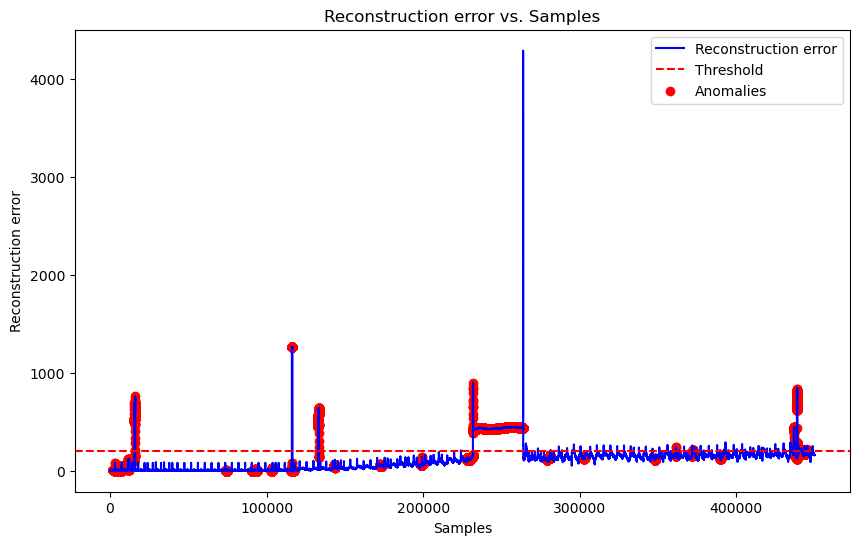

In [26]:
# 可视化重构误差
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, 'b', label='Reconstruction error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
# 标出异常点
plt.scatter(ano, reconstruction_error[ano], color='r', label='Anomalies')
plt.xlabel('Samples')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error vs. Samples')
plt.legend()
plt.show()

In [ ]:
# 封装PCA
class PCAReconstruction:
    def __init__(self, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

    def fit(self, X):
        self.pca.fit(X)

    def transform(self, X):
        return self.pca.transform(X)

    def inverse_transform(self, X):
        return self.pca.inverse_transform(X)

    def predict(self, X, threshold):
        X_reconstructed = self.pca.inverse_transform(self.pca.transform(X))
        reconstruction_error = np.sum((X - X_reconstructed) ** 2, axis=1)
        return reconstruction_error